# Detecting faces:
El siguiente notebook ejecuta un algoritmo el cual intenta identificar los rostros de algunas celebridades del dataset 'Labelled Faces in the Wild'.

In [1]:
# Funciones generales
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Biblioteca para entrenamiento y validación
from sklearn.model_selection import train_test_split

# Copia de archivos
import shutil

# Creación de CNN
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Dense #type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore

2025-08-31 17:04:34.698006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 17:04:35.310680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756677875.572991    5058 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756677875.628421    5058 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756677876.112870    5058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Extrayendo los datos de Kaggle

In [2]:
import kagglehub #type:ignore
path_kaggle_dataset = kagglehub.dataset_download('jessicali9530/lfw-dataset')

# Ruta al archivo CSV
csv_path = os.path.join(path_kaggle_dataset, 'lfw_allnames.csv')
df_faces_dataset = pd.read_csv(csv_path)
df_faces_dataset.head()

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1


## Creando las rutas de cada imagen

In [3]:
# repite cada fila de acuerdo a la cantidad de imagenes que almacena
df_images_paths = df_faces_dataset.loc[df_faces_dataset.index.repeat(df_faces_dataset["images"])]
# suma acumulada de cada imagen que almacena
df_images_paths["path_img"] = df_images_paths.groupby("name").cumcount() + 1
# cantidad de imagen que alamcena de completa con 0 hasta 4 cifras
df_images_paths["path_img"] = df_images_paths.path_img.apply(lambda x: f"{x:04}")
# formato de la ruta de cada imagen
df_images_paths["path_img"] = df_images_paths.name + "/" + df_images_paths.name + "_" + df_images_paths.path_img + ".jpg"
df_images_paths = df_images_paths.drop("images", axis=1)
df_images_paths.head()

,name,path_img
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg


In [4]:
# verificando la resolucion de las imágenes
widths = []
heights = []

rutas = df_images_paths["path_img"]
for file in rutas:
    # ruta de cada imagen en kaggle
    path_img = os.path.join(path_kaggle_dataset, "lfw-deepfunneled/lfw-deepfunneled", str(file))
    imagen = load_img(path_img, target_size=(128,128))
    widths.append(imagen.width)
    heights.append(imagen.height)

dimensiones = pd.DataFrame({"Height": heights, "Widths": widths})
print(dimensiones.describe())

        Height   Widths
count  13233.0  13233.0
mean     128.0    128.0
std        0.0      0.0
min      128.0    128.0
25%      128.0    128.0
50%      128.0    128.0
75%      128.0    128.0
max      128.0    128.0


                name  count
0      George_W_Bush    530
1       Colin_Powell    236
2         Tony_Blair    144
3    Donald_Rumsfeld    121
4  Gerhard_Schroeder    109
5       Ariel_Sharon     77


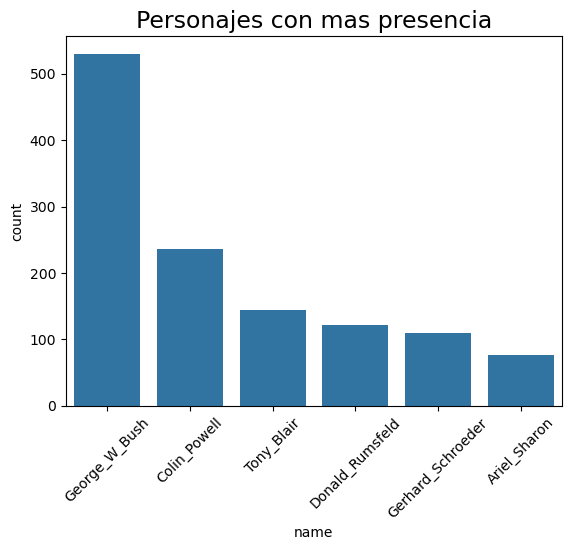

In [5]:
# distribución de la cantidad imagenes por cada personaje
names_top = df_images_paths.name.value_counts().sort_values(ascending=False).reset_index().iloc[:6,]
print(names_top)
sns.barplot(data=names_top, x="name", y="count")
plt.xticks(rotation=45)
plt.title("Personajes con mas presencia", size=17)
plt.show()

Para este proyecto se tomará la predicción del personaje George W. Bush ya que cuenta con
una mayor cantidad de imágenes

In [6]:
# Separando los datos que pertenecen al personaje seleccionado
bush_data = df_images_paths.loc[df_images_paths["name"]=="George_W_Bush"]
bush_data.reset_index(drop=True, inplace=True)

In [7]:
# Seleccionamos de las imágenes que no pertenecen al personaje seleccionado
# una cantidad igual de imágenes
no_bush_data = df_images_paths.loc[df_images_paths["name"]!="George_W_Bush"]
no_bush_data.reset_index(drop=True, inplace=True)
no_bush_data.loc[:, "name"] = "no_George_W_Bush"

In [8]:
# Uniendo los datos seleccionados
rutas_imagenes = pd.concat([bush_data, no_bush_data], axis=0)
rutas_imagenes.name.value_counts()

name
no_George_W_Bush    12703
George_W_Bush         530
Name: count, dtype: int64

In [9]:
# Separando los directorios de los datos de entrenamiento y validación
bush_train, bush_test = train_test_split(rutas_imagenes,
                                         test_size=0.2,
                                         stratify=rutas_imagenes["name"],
                                         shuffle=True,
                                         random_state=42)

## Estableciendo las funciones de uso

Creando los directorios para mover las imágenes

In [10]:
import shutil

def make_directory_1(ruta, data):
    cont = 0

    for i in data["path_img"]:
        if not os.path.exists(os.path.join("../../../../../data_main/", ruta)):
            os.mkdir(os.path.join("../../../../../data_main/", ruta))

        name_file = data.loc[data["path_img"]==i]["name"]
        name_file = str(list(name_file)[0])

        if not os.path.exists(os.path.join("../../../../../data_main/", ruta, name_file)):
            os.mkdir(os.path.join("../../../../../data_main/", ruta, name_file))

        data_from = os.path.join(path_kaggle_dataset, "lfw-deepfunneled/lfw-deepfunneled", i)
        data_to = os.path.join("../../../../../data_main/", ruta, name_file)
        shutil.copy(data_from, data_to)
        cont += 1

    print(f"Se movieron {cont} imágenes a carpeta {ruta}")

make_directory_1('train_bush/', bush_train)
make_directory_1('test_bush/', bush_test)

Se movieron 10586 imágenes a carpeta train_bush/
Se movieron 2647 imágenes a carpeta test_bush/


## Implementación de la red neuronal convolucional

In [11]:
# Estableciendo los callbacks con el cual se optimiza el modelo
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler]

In [12]:
imagen_de_muestra = os.path.join("../../../../../data_main/", "train_bush", "George_W_Bush", "George_W_Bush_0001.jpg")
imagen = load_img(imagen_de_muestra)
imagen_array = img_to_array(imagen)
imagen_array.shape

(250, 250, 3)

In [13]:
model_conv = Sequential()
model_conv.add(Input((128,128,3)))
model_conv.add(Conv2D(filters=6, kernel_size=(5,5), activation="relu"))
model_conv.add(MaxPooling2D(pool_size=(2,2)))

model_conv.add(Conv2D(filters=16, kernel_size=(5,5), activation="relu"))
model_conv.add(MaxPooling2D(pool_size=(2,2)))

model_conv.add(Flatten())
model_conv.add(Dense(120, activation="relu"))
model_conv.add(Dense(84, activation="relu"))
model_conv.add(Dense(1, activation="sigmoid"))

I0000 00:00:1756677914.522236    5058 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Compilando el modelo

In [14]:
model_conv.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

set_train = train_datagen.flow_from_directory("../../../../../data_main/train_bush/",
                                                       target_size=(128,128),
                                                       #Agrupa las imágenes en lotes (batch_size=32), lo que significa que ya tienen una dimensión extra: (32, 128, 128, 3).
                                                       batch_size=32,
                                                       class_mode="binary")
set_test = test_datagen.flow_from_directory("../../../../../data_main/test_bush/",
                                                  target_size=(128,128),
                                                  batch_size=15,
                                                  class_mode="binary")

Found 10586 images belonging to 2 classes.
Found 2647 images belonging to 2 classes.


In [16]:
history_conv = model_conv.fit(set_train,
                              epochs=15,
                              validation_data=set_test,
                              callbacks=callbacks)

Epoch 1/15


/home/leonardope/mambaforge/envs/estudio/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756677917.666747   12889 service.cc:152] XLA service 0x78acd00057e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756677917.666814   12889 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-31 17:05:17.738338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756677918.002841   12889 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-31 17:05:19.

  3/331 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.8611 - loss: 0.5760

I0000 00:00:1756677922.390371   12889 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 96/331 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.9550 - loss: 0.2176

2025-08-31 17:05:33.916436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_294', 4 bytes spill stores, 4 bytes spill loads

2025-08-31 17:05:34.229646: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_294', 56 bytes spill stores, 56 bytes spill loads

2025-08-31 17:05:34.588090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 52 bytes spill stores, 52 bytes spill loads



331/331 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.9597 - loss: 0.1622 - val_accuracy: 0.9660 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 2/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9655 - loss: 0.1070 - val_accuracy: 0.9743 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 3/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9753 - loss: 0.0787 - val_accuracy: 0.9728 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 4/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.9757 - loss: 0.0706 - val_accuracy: 0.9830 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 5/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - accuracy: 0.9821 - loss: 0.0522 - val_accuracy: 0.9830 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 6/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - accuracy: 0.9847 - loss: 0.0478 - val_accuracy: 0.9807 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 7/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9877 - loss: 0

## Graficando las métricas de Accuracy y Loss

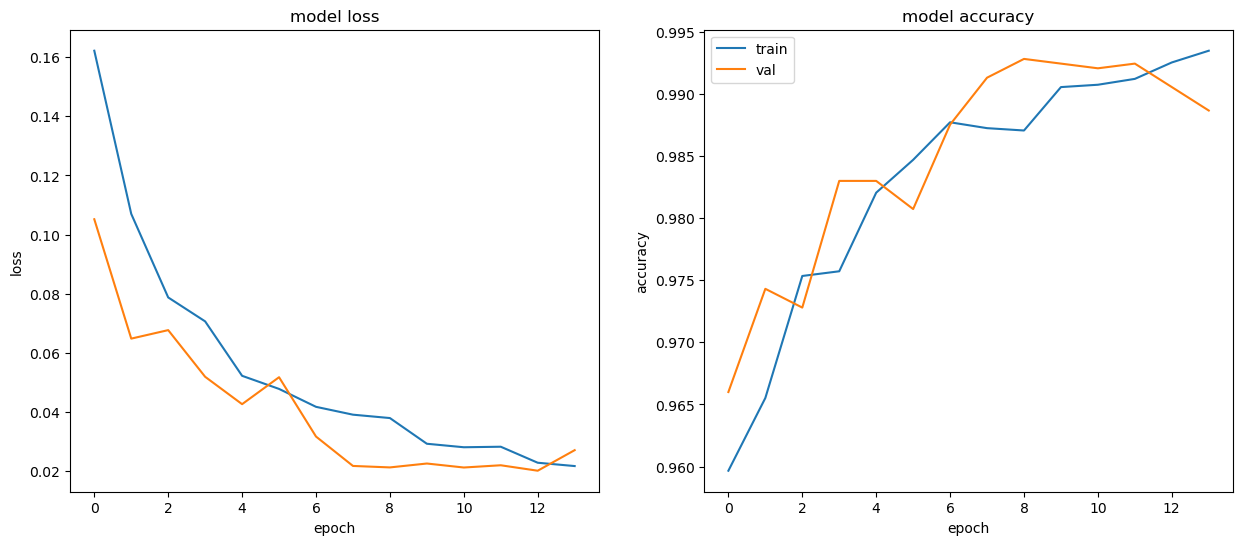

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(history_conv.history['loss'], label="train")
ax[0].plot(history_conv.history['val_loss'], label="val")
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(history_conv.history['accuracy'], label="train")
ax[1].plot(history_conv.history['val_accuracy'], label="val")
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
plt.legend()
plt.show()

Definiendo el orden de los nombres de las clases

In [18]:
from collections import OrderedDict
names = []
# obteniendo todos los nombres de los archivos de set_test.filenames en una lista
for i in range(len(set_test.filenames)):
    names.append(set_test.filenames[i])
# extrayendo el primer nombre de cada archivo
for i in range(len(names)):
    names[i] = names[i].split("/")[0]
# eliminación de duplicados y se convierte a una lista
names = list(OrderedDict.fromkeys(names))
values = range(len(names))
guia = {value: name for value, name in zip(values, names)}
guia

{0: 'George_W_Bush', 1: 'no_George_W_Bush'}

## Realizando las predicciones

In [19]:
# función para predicciones
def make_predict(ruta, model, binary):
    predictions = []
    for i in os.listdir(ruta):
        test_image = load_img(ruta + "/" + str(i), target_size=(128,128))
        test_image = img_to_array(test_image)
        # se añade una dimensión mas 
        test_image = np.expand_dims(test_image, axis=0)
    
        if binary is True:
            result = float(model.predict(test_image, verbose=0)[0][0])
        else:
            result = np.argmax(model.predict(test_image, verbose=0))
        predictions.append(result)
    return predictions

In [20]:
ruta_test_bush = os.path.join("../../../../../data_main/test_bush/", guia[0])
ruta_test_no_bush = os.path.join("../../../../../data_main/test_bush/", guia[1])
predicciones_bush = make_predict(ruta_test_bush, model_conv, binary=True)
predicciones_no_bush = make_predict(ruta_test_no_bush, model_conv, binary=True)

In [21]:
predicciones_bush_name = [guia[value] if value in guia else 'no_George_W_Bush' for value in predicciones_bush]
predicciones_no_bush_name = [guia[value] if value in guia else 'George_W_Bush' for value in predicciones_no_bush]

In [22]:
predicciones_total = pd.DataFrame(zip(predicciones_bush_name + predicciones_no_bush_name,
                                      ['George_W_Bush']*len(predicciones_bush_name) + 
                                      ['no_George_W_Bush']*len(predicciones_no_bush_name)),
                                      columns=["Predicciones", "Valores_reales"])
predicciones_total.head()

,Predicciones,Valores_reales
0,George_W_Bush,George_W_Bush
1,George_W_Bush,George_W_Bush
2,George_W_Bush,George_W_Bush
3,George_W_Bush,George_W_Bush
4,George_W_Bush,George_W_Bush


## Realizando la matriz de confusion

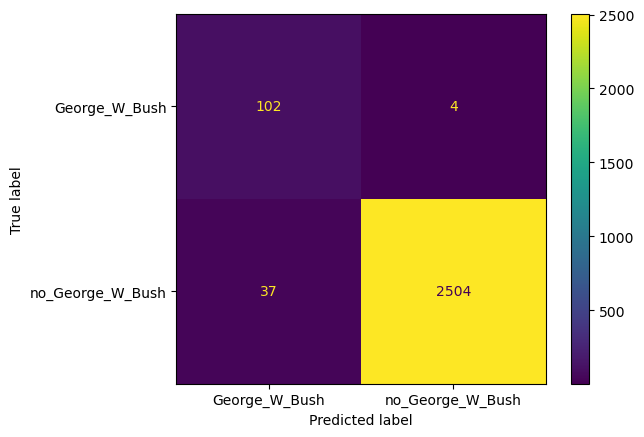

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicciones_total["Valores_reales"], predicciones_total["Predicciones"])
dist = ConfusionMatrixDisplay(cm, display_labels=names)
dist.plot()
plt.show()

In [24]:
loss, accuracy = model_conv.evaluate(set_test, verbose=0)
print(F"El valor de la pérdida es: {round(loss, 3)}")
print(f"La precisión del modelo es de: {round(accuracy*100, 1)}%")

El valor de la pérdida es: 0.021
La precisión del modelo es de: 99.3%


In [30]:
from sklearn.metrics import classification_report

matrix_cr = classification_report(predicciones_total["Valores_reales"], predicciones_total["Predicciones"], output_dict=True)
matrix_cr

{'George_W_Bush': {'precision': 0.7338129496402878,
  'recall': 0.9622641509433962,
  'f1-score': 0.8326530612244898,
  'support': 106.0},
 'no_George_W_Bush': {'precision': 0.9984051036682615,
  'recall': 0.9854388036206218,
  'f1-score': 0.9918795801148742,
  'support': 2541.0},
 'accuracy': 0.9845107669059312,
 'macro avg': {'precision': 0.8661090266542746,
  'recall': 0.973851477282009,
  'f1-score': 0.9122663206696819,
  'support': 2647.0},
 'weighted avg': {'precision': 0.9878094223962686,
  'recall': 0.9845107669059312,
  'f1-score': 0.9855033009299929,
  'support': 2647.0}}

In [36]:
round(matrix_cr["George_W_Bush"]["precision"],2)*100

73.0

In [45]:
print(f"""Interpretación:\n\
      George_W_Bush:\n\
      Precision: El {round(matrix_cr['George_W_Bush']['precision'],2)*100}% de las veces que el modelo predijo 'George_W_Bush', acertó.\n\
      Recall: El modelo detectó correctamente el {round(matrix_cr['George_W_Bush']['recall'],2)*100}% de las imágenes que realmente eran de George W. Bush.\
      \n\
      no_George_W_Bush:\n\
      Precision: El {round(matrix_cr['no_George_W_Bush']['precision'],2)*100}% de las veces que el modelo predijo 'no_George_W_Bush', acertó.\n\
      Recall: El modelo detectó correctamente el {round(matrix_cr['no_George_W_Bush']['recall'],2)*100}% de las imágenes que realmente no eran de George W. Bush.""")

Interpretación:
      George_W_Bush:
      Precision: El 73.0% de las veces que el modelo predijo 'George_W_Bush', acertó.
      Recall: El modelo detectó correctamente el 96.0% de las imágenes que realmente eran de George W. Bush.      
      no_George_W_Bush:
      Precision: El 100.0% de las veces que el modelo predijo 'no_George_W_Bush', acertó.
      Recall: El modelo detectó correctamente el 99.0% de las imágenes que realmente no eran de George W. Bush.


## Guardando el mejor modelo

In [26]:
# from tensorflow.keras.models import load_model #type:ignore

# model_conv.save("../../models/model_faces_bin.keras")